# Statement 2

We will work now with a satellital image. The aim is to do a segmentation of an image which shows vegetation and concrete areas. You can use whatever technique you want, we only want to see how you approach the problem.

    

In [10]:
!pip install pandas numpy matplotlib opencv-python 

## Imports and Image Loading

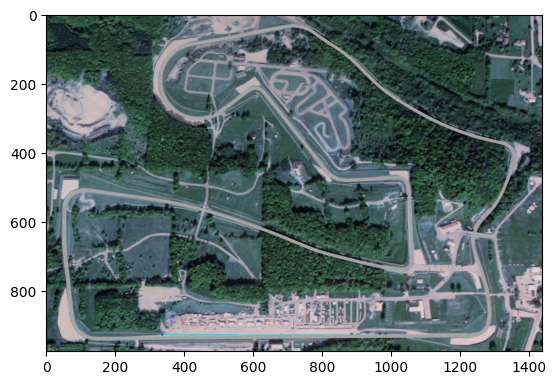

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the satellite image using OpenCV (in BGR format by default)
satellital_im = cv2.imread('satellital_im.jpg')
# Preview raw image (in BGR color space, may show distorted colors in matplotlib)
plt.imshow(satellital_im)

## BGR to RGB image

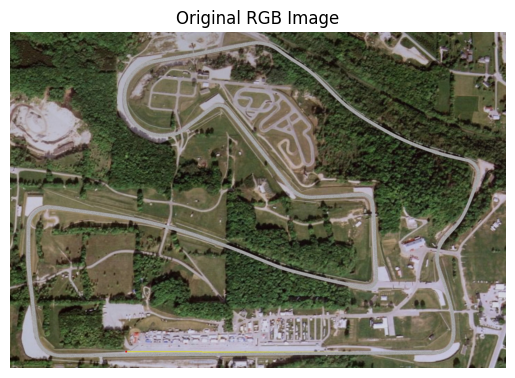

In [2]:
# Converting the image from BGR to RGB for proper visualization in matplotlib
satellital_rgb = cv2.cvtColor(satellital_im, cv2.COLOR_BGR2RGB)
# Display the RGB image
plt.imshow(satellital_rgb)
plt.title("Original RGB Image")
plt.axis("off")
plt.show()

## RESIZING IMAGE

In [3]:
# Resizing image to 512x512 for faster processing and consistency
resized_rgb = cv2.resize(satellital_rgb, (512, 512))

In [4]:
# Converting the RGB image to HSV color space for better segmentation capability
hsv_image = cv2.cvtColor(resized_rgb, cv2.COLOR_RGB2HSV)

## SPLIT HSV CHANNELS

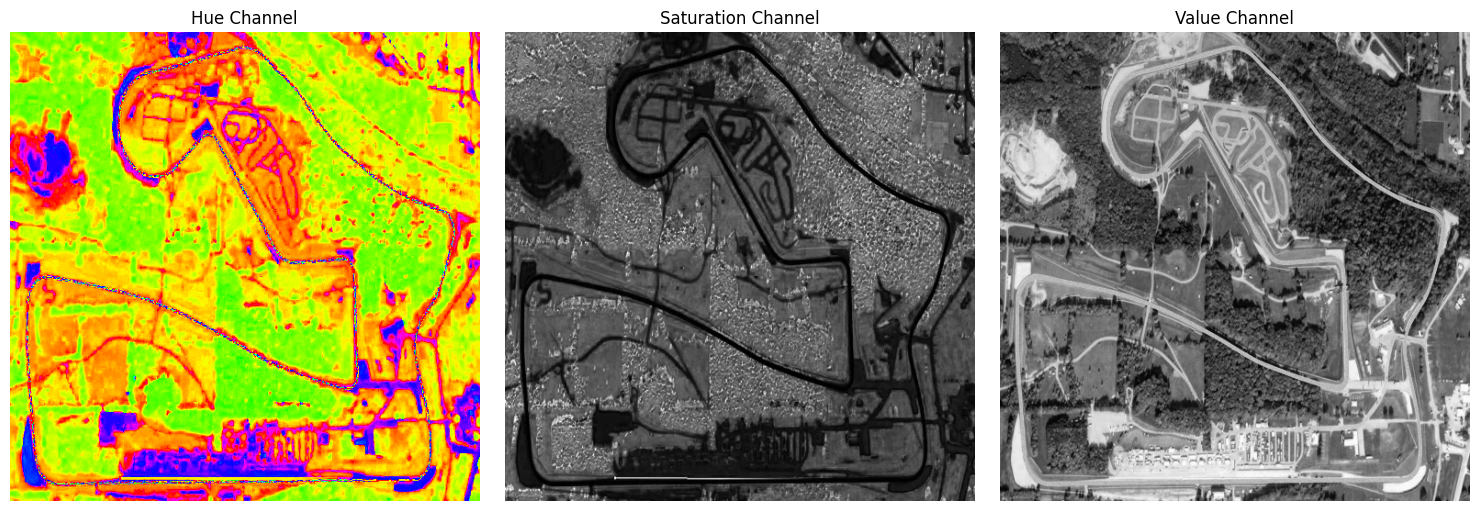

In [5]:
# Separating HSV image into Hue, Saturation, and Value channels
hue, sat, val = cv2.split(hsv_image)

# Visualize individual HSV channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(hue, cmap='hsv')
axes[0].set_title('Hue Channel')
axes[0].axis('off')

axes[1].imshow(sat, cmap='gray')
axes[1].set_title('Saturation Channel')
axes[1].axis('off')

axes[2].imshow(val, cmap='gray')
axes[2].set_title('Value Channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Define HSV Thresholds 

In [6]:
# 1. Vegetation (Green)
# Hue: ~35-90 (capturing a range of greens, avoiding yellows and cyans)
# Saturation: ~30-255 (needs to have noticeable color, not too grayish)
# Value: ~30-255 (not too dark, to avoid deep shadows being misclassified if possible)
# Defining threshold ranges for detecting vegetation (green areas)
lower_green = np.array([35, 30, 30])
upper_green = np.array([90, 255, 255])
vegetation_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# 2. Concrete, Bare Ground, Roads (Gray, White, Light Tan/Brown)
# These areas are characterized by low saturation.
# Hue: 0-180 (any hue, as grays don't have a strong hue)
# Saturation: 0-70 (low saturation, distinguishing from vibrant colors)
# Value: 70-255 (mid to high brightness; avoids very dark shadows on concrete,
# and captures bright concrete/white structures/quarry)
lower_concrete = np.array([0, 0, 70])
upper_concrete = np.array([180, 70, 255])
concrete_candidate_mask = cv2.inRange(hsv_image, lower_concrete, upper_concrete)

# To avoid any overlap with vegetation
concrete_mask = cv2.bitwise_and(concrete_candidate_mask, concrete_candidate_mask, mask=cv2.bitwise_not(vegetation_mask))


## Morphological Cleaning 

In [7]:
# Applying morphological closing to fill small holes and gaps within the concrete mask
# (useful for creating more solid and connected regions)
kernel = np.ones((5, 5), np.uint8)
vegetation_mask = cv2.morphologyEx(vegetation_mask, cv2.MORPH_CLOSE, kernel)
concrete_mask = cv2.morphologyEx(concrete_mask, cv2.MORPH_CLOSE, kernel)

## Generate Segmented Output 

In [8]:
segmented_image = np.zeros_like(resized_rgb)
segmented_image[vegetation_mask > 0] = [0, 128, 0]      # Dark green for vegetation
segmented_image[concrete_mask > 0] = [128, 128, 128]    # Gray for concrete

## DISPLAY MASKS

## Segmented Output

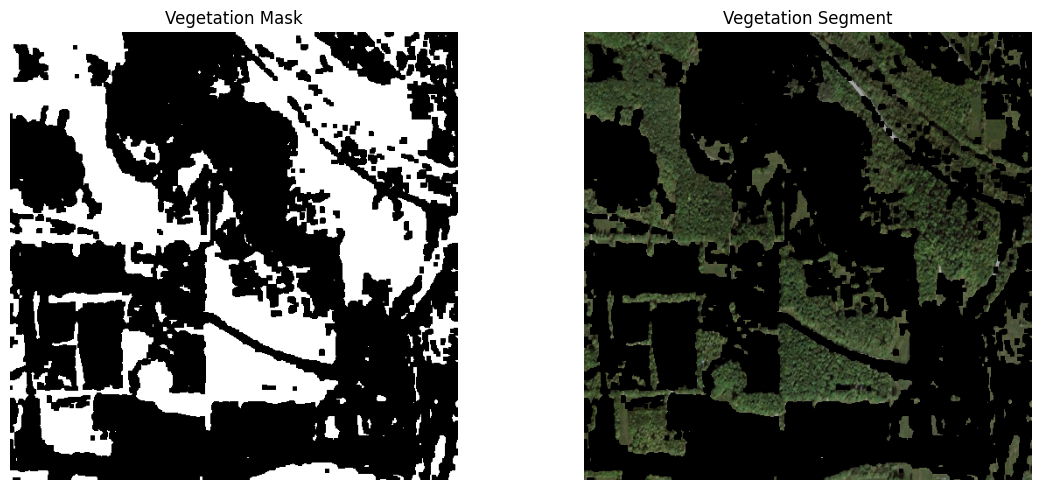

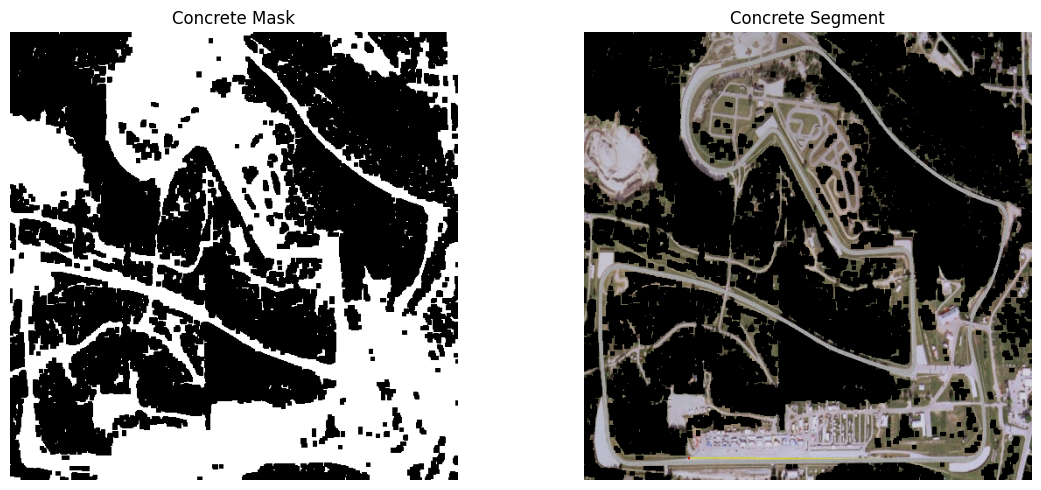

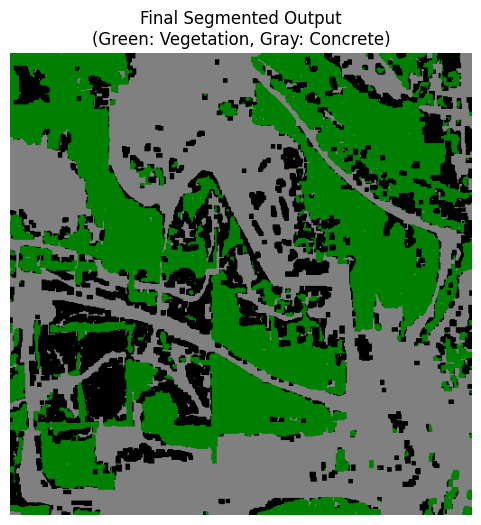

In [9]:
# Resized image to match mask
resized_rgb = cv2.resize(satellital_rgb, (vegetation_mask.shape[1], vegetation_mask.shape[0]))

# Vegetation Mask and Segment
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(vegetation_mask, cmap='gray')
plt.title("Vegetation Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
vegetation_segment = cv2.bitwise_and(resized_rgb, resized_rgb, mask=vegetation_mask)
plt.imshow(vegetation_segment)
plt.title("Vegetation Segment")
plt.axis("off")
plt.tight_layout()
plt.show()

# Concrete Mask and Segment
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(concrete_mask, cmap='gray')
plt.title("Concrete Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
concrete_segment = cv2.bitwise_and(resized_rgb, resized_rgb, mask=concrete_mask)
plt.imshow(concrete_segment)
plt.title("Concrete Segment")
plt.axis("off")
plt.tight_layout()
plt.show()

# Final Segmented Visualization
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image)
plt.title("Final Segmented Output\n(Green: Vegetation, Gray: Concrete)")
plt.axis("off")
plt.show()


## Vegetation & Concrete Segmentation Approach (HSV-based)

1. **Image Preprocessing**:
   - Read input image.
   - Converting from BGR → RGB → HSV.
   - Resizing to 512×512 for consistent processing.

2. **HSV Channel Analysis**:
   - Visualizing individual **Hue**, **Saturation**, and **Value** components for better threshold calibration.

3. **Color Thresholding**:
   - Vegetation: Green hues (35–90), moderate saturation & value.
   - Concrete/Bare Ground: Low saturation (0–70), high value (70–255), all hues allowed.

4. **Overlap Resolution**:
   - Ensuring pixels classified as vegetation aren't reclassified as concrete.

5. **Mask Cleaning**:
   - Using morphological **closing** (dilation + erosion) to remove small holes and noise.

6. **Final Segmentation Visualization**:
   - Using a color-coded image to show:
     - Vegetation in dark green.
     - Concrete in gray.
     - Unclassified areas in black.

This method is **efficient**, **interpretable**, and well-suited for remote sensing imagery where colors correlate strongly with material types.
